# AML Exam

•

# 1. Importing Libraries

• Downloading external libraries

In [ ]:
!pip install opencv-python
!pip install tensorflow

• Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import shutil
from matplotlib import pyplot as plt

In [2]:
def remove_unwanted_folders(folder):
    if ".DS_Store" in folder:
        folder.remove(".DS_Store")
        print("Removed DS_Store")
    if ".ipynb_checkpoints" in folder:
        folder.remove(".ipynb_checkpoints")
        print("removed checkpoints")

# 2. Preparing and Augmenting Data

## 2.1 Augmenting Data to get more samples.
    • Flip Horizontal
    • Flip Vertical
    • Brightness
    • Contrast
    • Saturation

In [ ]:
# Get list of all disease folders in data
original_data_path = "./Data/original_data/"
original_data_folder = os.listdir(original_data_path)
remove_unwanted_folders(original_data_folder)


augmented_data_path = "./Data/aug_data/"
augmented_data_folder = os.listdir(augmented_data_path)

In [10]:
def save_Augmented_Image(save_path,img):
    cv2.imwrite(save_path,img)

for disease in original_data_folder: # Looping over all disease folders
    
    # Get all images inside of current disease folder
    images = os.listdir(os.path.join(original_data_path,disease))

    # Loading each image in folder
    for current_image in images:
        # Get full path of current image
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        
        #Save Original Image
        current_image_cv2 = cv2.imread(current_image_full_path)                                
        save_Augmented_Image(os.path.join(augmented_data_path, disease, "o_"+current_image),current_image_cv2)
        
        # Flip Horizontal
        horizontal_flip_image = cv2.flip(current_image_cv2,1)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,"fH_"+current_image),horizontal_flip_image)

        # Flip Vertical
        vertical_flip_image = cv2.flip(current_image_cv2,0)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,"fV_"+current_image),vertical_flip_image)

        # Adjust Brightness
        brightness_higher = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=70)
        brightness_lower = cv2.convertScaleAbs(current_image_cv2, alpha=1, beta=-40)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,"bH_"+current_image),brightness_higher)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,"bL_"+current_image),brightness_lower)

        # Adjust Contrast
        contrast_higher = cv2.convertScaleAbs(current_image_cv2, alpha=1.6, beta=0)
        contrast_lower = cv2.convertScaleAbs(current_image_cv2, alpha=0.7, beta=0)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,"cH_"+current_image),contrast_higher)
        save_Augmented_Image(os.path.join(augmented_data_path,disease,"cL_"+current_image),contrast_lower)
        

## 2.2 Saving augmented data into train, validation and test

In [22]:
# Get list of all disease folders in data
original_data_path = "./Data/aug_data/"
original_data_folder = os.listdir(original_data_path)

remove_unwanted_folders(original_data_folder)
print(original_data_folder)

removed checkpoints
['FU-athlete-foot', 'VI-chickenpox', 'VI-shingles', 'FU-nail-fungus', 'BA-impetigo', 'PA-cutaneous-larva-migrans', 'FU-ringworm', 'BA- cellulitis']


In [24]:
for disease in original_data_folder:
    # Get all images inside each corresponding disease folder
    images = np.array(os.listdir(os.path.join(original_data_path,disease)))
    
    # Specify train, test and validation sizes
    train_partition = int(len(images)*.7)
    validation_partition = int(len(images)*.2)
    test_partition = int(len(images)*.1)
    
    # Empty lists to store all numbers in range into a list.
    train_partition_indexes = []
    validation_partition_indexes = []
    test_partition_indexes = []
    
    # Array of Train images from partition.
    for x in range(0,train_partition):
        train_partition_indexes.append(x)
    train_image_array = np.take(images,train_partition_indexes)
    
    # Array of Validation images from partition.
    for x in range(train_partition, train_partition + validation_partition):
        validation_partition_indexes.append(x)
    validation_image_array = np.take(images, validation_partition_indexes)
    
    # Array of Test images from partition.
    for x in range(train_partition + validation_partition , train_partition + validation_partition + test_partition):
        test_partition_indexes.append(x)
    test_image_array = np.take(images, test_partition_indexes)
        
    
    # Used for Generating disease folders in train, validation and test directories.
    #os.mkdir(f"./Data/data/train/{disease}")
    #os.mkdir(f"./Data/data/test/{disease}")
    #os.mkdir(f"./Data/data/val/{disease}")
    
    # Defining path to new folders
    train_folder_path = "./Data/data/train/"
    validation_folder_path = "./Data/data/val/"
    test_folder_path = "./Data/data/test/"
    
    # Moving images to their respective train, validation and test folders
    # • Train Images
    for current_image in train_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(train_folder_path, disease, current_image))

    # • Validation Images
    for current_image in validation_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(validation_folder_path, disease, current_image))
    
    # • Test Images
    for current_image in test_image_array:
        current_image_full_path = os.path.join(original_data_path, disease, current_image)
        shutil.copyfile(current_image_full_path, os.path.join(test_folder_path, disease, current_image)) 
    


# 3. Model Creation

## 3.1 ???

### • Importing Libraries

### • Load processed data

### • Define Model

### • Train Model

### • Export model as pickle

## 3.2 Convolutional Neural Network (CNN)

### • Defining Image Paths

In [ ]:
train_path = "./Data/data/train/" # Augmented Data
train_path = "./Data/original_data/" # Original Data
train_folder = os.listdir(train_path)
remove_unwanted_folders(train_folder)

val_path = "./Data/data/val/" # Augmented Data
val_path = "./Data/original_data/" # Original Data
val_folder = os.listdir(val_path)
remove_unwanted_folders(val_folder)

test_path = "./Data/data/test/" # Augmented Data
test_path = "./Data/original_data/" # Original Data
test_folder = os.listdir(test_path)
remove_unwanted_folders(test_folder)

### • Loading data with tensorflow

In [5]:
train = tf.keras.utils.image_dataset_from_directory("./Data/data/train",image_size=(224,224))
val = tf.keras.utils.image_dataset_from_directory("./Data/data/val", image_size=(224,224))
#test = tf.keras.utils.image_dataset_from_directory("./Data/data/test")

Found 5670 files belonging to 8 classes.
Found 1614 files belonging to 8 classes.


### • Transforming from regular 0-255 values to 0-1 values

In [735]:
#train = train.map(lambda x,y: (x/255, y))
#val = val.map(lambda x,y: (x/255, y))
#test = test.map(lambda x,y: (x/255, y))

In [736]:
#train_size = int(len(data)*.7)
#val_size = int(len(data)*.2)
#test_size = int(len(data)*.1)

In [737]:
#train = data.take(train_size)
#val = data.skip(train_size).take(val_size)
#test = data.skip(train_size+val_size).take(test_size)

### • Importing Tensorflow libraries for CNN model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
model = Sequential()

### • Defining Model Structure

In [751]:
# Github
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax'))
model.add(Dropout(0.25))


In [713]:
# Tensorflow
model.add(Conv2D(16, 3, 1,activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, 1,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, 1,activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.add(Dropout(0.25))

In [8]:
#test
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3),  activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

### • Compiling and training model

In [10]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
logdir='logs'

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
178/178 [==============================] - 312s 2s/step - loss: 2.4407 - accuracy: 0.2053 - val_loss: 1.9932 - val_accuracy: 0.1902
Epoch 2/10
178/178 [==============================] - 1254s 7s/step - loss: 1.9138 - accuracy: 0.2758 - val_loss: 1.9343 - val_accuracy: 0.2441
Epoch 3/10
178/178 [==============================] - 641s 4s/step - loss: 2.0527 - accuracy: 0.2185 - val_loss: 2.0463 - val_accuracy: 0.1735
Epoch 4/10
178/178 [==============================] - 461s 3s/step - loss: 2.0209 - accuracy: 0.1831 - val_loss: 1.9931 - val_accuracy: 0.2057
Epoch 5/10
178/178 [==============================] - 324s 2s/step - loss: 1.9485 - accuracy: 0.2265 - val_loss: 1.8412 - val_accuracy: 0.2800
Epoch 6/10
178/178 [==============================] - 334s 2s/step - loss: 1.8384 - accuracy: 0.3122 - val_loss: 1.9199 - val_accuracy: 0.2546
Epoch 7/10
178/178 [==============================] - 338s 2s/step - loss: 1.5979 - accuracy: 0.4157 - val_loss: 1.2900 - val_accuracy: 0.547

### • Plotting Results

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

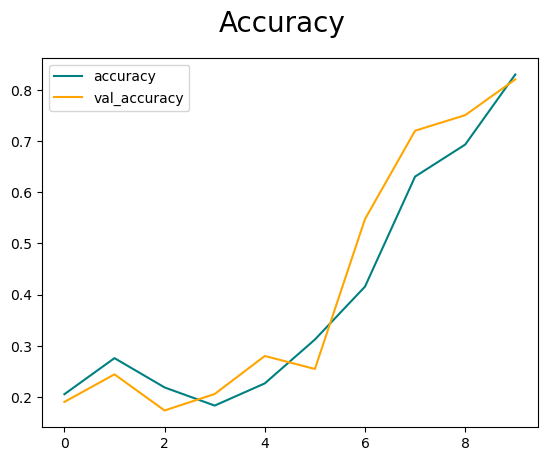

In [15]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### • Mapping Classes to indexes

In [32]:
class_map = {
    0: 'BA- cellulitis',
    1: 'BA-impetigo',
    2: 'FU-athlete-foot',
    3: 'FU-nail-fungus',
    4: 'FU-ringworm',
    5: 'PA-cutaneous-larva-migrans',
    6: 'VI-chickenpox',
    7: 'VI-shingles'}

### • Loading and resizing image for test prediction

In [ ]:
img = cv2.imread('./Data/data/test/BA- cellulitis/bH_BA- cellulitis (66).jpg')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
pred_image = resize/255

yhat = model.predict(np.expand_dims(pred_image, 0))

print(yhat)
class_label = np.argmax(yhat)
predicted_class = f"{class_map[class_label]}"
predicted_class

### • Export model as pickle

In [31]:
model.save(os.path.join("./Saved_Models","CNN_V1.h5"))

## 3.3 Support Vector Machine (SVM)

### • Importing Libraries

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pickle
import warnings
warnings.filterwarnings("ignore")

### • Preprocess data

In [7]:
train_path = "./Data/data/train/" # Augmented Data
train_folder = os.listdir(train_path)
remove_unwanted_folders(train_folder)

val_path = "./Data/data/val/" # Augmented Data
val_folder = os.listdir(val_path)
remove_unwanted_folders(val_folder)

test_path = "./Data/data/test/" # Augmented Data
test_folder = os.listdir(test_path)
remove_unwanted_folders(test_folder)

### • Loading Images and creating Numpy Arrays

In [8]:
train_x = []
train_y = []

test_x = []
test_y = []

# Gathering Training Data
for disease in train_folder:
    images = os.listdir(os.path.join(train_path,disease))
    for current_image in images:
        # Load every image in current disease folder as cv2 image
        current_image_full_path = os.path.join(train_path,disease,current_image)
        current_image = cv2.imread(current_image_full_path)
        current_image = cv2.resize(current_image,(224,224))
        
        train_x.append(current_image.flatten())
        train_y.append(disease)
        
        
# Gathering Test Data
for disease in test_folder:
    images = os.listdir(os.path.join(test_path,disease))
    for current_image in images:
        # Load every image in current disease folder as cv2 image
        current_image_full_path = os.path.join(test_path,disease,current_image)
        current_image = cv2.imread(current_image_full_path)
        current_image = cv2.resize(current_image,(224,224))
        
        test_x.append(current_image.flatten())
        test_y.append(disease)
        
# Adding Val images to test array
for disease in val_folder:
    images = os.listdir(os.path.join(val_path,disease))
    for current_image in images:
        # Load every image in current disease folder as cv2 image
        current_image_full_path = os.path.join(val_path,disease,current_image)
        current_image = cv2.imread(current_image_full_path)
        current_image = cv2.resize(current_image,(224,224))
        
        test_x.append(current_image.flatten())
        test_y.append(disease)

In [9]:
# Checking Shape of Training Data
train_x = np.array(train_x).reshape(len(train_x), -1)/255
train_y = np.array(train_y)
print(f"Train_x Shape: {train_x.shape}\nTrain_y Shape: {train_y.shape}\n")


# Checking Shape of Test Data
test_x = np.array(test_x).reshape(len(test_x), -1)/255
test_y = np.array(test_y)
print(f"Test_x Shape: {test_x.shape}\nTest_y Shape: {test_y.shape}")

Train_x Shape: (5675, 150528)
Train_y Shape: (5675,)

Test_x Shape: (2431, 150528)
Test_y Shape: (2431,)


### • Train Support Vector Classifier (SVC)

In [282]:
svc = SVC(kernel="rbf")
svc.fit(train_x,train_y)

SVC()

### • Generate Accuracy Score

In [ ]:
y_pred_train = svc.predict(train_x)
y_pred_test = svc.predict(test_x)
print("Training accuracy:  ", accuracy_score(train_y,y_pred_train))
print("Test accuracy:  ", accuracy_score(test_y,y_pred_test))

### • Classification Report

In [262]:
#y_pred = svc.predict(test_x)
c_report = classification_report(test_y,y_pred)
print(c_report)

                            precision    recall  f1-score   support

            BA- cellulitis       0.91      0.94      0.92       170
               BA-impetigo       0.93      0.69      0.79       100
           FU-athlete-foot       0.97      0.96      0.96       156
            FU-nail-fungus       0.83      0.89      0.86       162
               FU-ringworm       0.82      0.73      0.77       113
PA-cutaneous-larva-migrans       0.92      0.87      0.90       125
             VI-chickenpox       0.97      0.96      0.96       170
               VI-shingles       0.75      0.91      0.83       163

                  accuracy                           0.88      1159
                 macro avg       0.89      0.87      0.87      1159
              weighted avg       0.89      0.88      0.88      1159



### • Load model

In [12]:
svc = pickle.load(open("./Saved_Models/svc.h5", 'rb'))

### • Predict with model

In [15]:
# Load new image to predict
predict_image = cv2.imread('./Data/data/val/VI-chickenpox/bH_145_VI-chickenpox (8).jpg')
predict_image = cv2.resize(predict_image, (224,224))
predict_image = np.array(predict_image.flatten()).reshape(1,-1)/255

In [16]:
svc.predict(predict_image)

array(['VI-chickenpox'], dtype='<U26')

### • Export model as pickle

In [283]:
pickle.dump(svc, open("./Saved_Models/svc.h5", 'wb'))

# 4. Model Evaluation

## 4.1 Testing Models

### • Test functionality

### • Gather datapoints for visualization

## 4.2 Visualisations

### Visualizing with matplotlib:
    • Test Loss
    • Test Accuracy
    • Visualise all model performances
    • Visualise images with predicted area of infection

## 4.3 Saving Predictions

### Save predictions to "predicted_data" folder